# 7. Алгоритмы оптимизации


Что я хотел сказать этой тетрадкой?  
Просто поговорить про поиски минимумов и максимумов, ведь скоро будут нейросети,  
а значит потребуется не ядро, а ЯДРИЩЕЕЕ всего ML - градиентный спуск


Прежде чем приступить к описанию и использованию семейства градиентных спусков,  
хотел бы сказать, что существуют и другие методы (ВАААУ, ШТООО), которые не используют в  
своей теории производные функции, что крайне занятно, я рассмотрю один и попробую  
использовать его для обучения какого-нибудь алгоритма


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

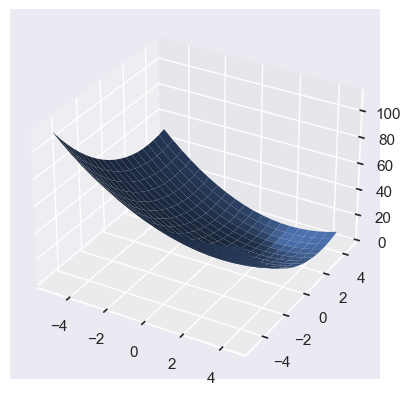

In [164]:
def f(x: float | np.ndarray) -> float | np.ndarray:
    w = np.asarray([3, 2])
    x = x.reshape(-1, 2)
    return np.sum((x - w) ** 2, axis=1)


x = np.arange(-5, 5, 0.5)
s = len(x)

x = np.asarray(np.meshgrid(x, x))
x_values = x.T.reshape(-1, 2)
z = f(x_values).T.reshape(s, s)


ax = plt.figure().add_subplot(projection="3d")
surf = ax.plot_surface(x[0], x[1], z, linewidth=0)
plt.show()

Используем функцию выше для отработки ударов


## Метод Нелдера — Мида (Nelder–Mead method)


В чем соль - в подъездах, ну или суставах пожилых людей,
симплекс - это n-мерный треугольник/тетраэдр, берём n+1 точек, строим симплекс


In [214]:
from typing import Callable


def nelder_mead(
    x: np.ndarray | np.matrix,
    fx: Callable[[np.ndarray | float], np.ndarray | float],
    alpha: float = 1,
    gamma: float = 2,
    beta: float = 0.5,
    delta: float = 0.5,
    init: np.ndarray | float | None = None,
    maxiter: int = 1000,
    err: float = 1e-6,
) -> np.ndarray:
    # Обработка входного массива точек
    if not isinstance(x, (np.ndarray, np.matrix)):
        x = np.asarray(x)

    # Должна быть матрица из n объектов с d размерном пространстве
    if len(x.shape) > 2:
        raise ValueError("X shape have to be (n, d) where n - points, d - coordinates")
    elif len(x.shape) < 2:
        x = x.reshape(-1, 1)

    # Проверка границ коэффициентов
    if not (alpha > 0):
        raise ValueError("Alpha have to be more than 0")
    if not (gamma > 1):
        raise ValueError("Gamma have to be more than 0")
    if not (0 < beta <= 0.5):
        raise ValueError("Beta have to be more than 1")
    if not (0 < delta <= 0.5):
        raise ValueError("Delta have to be more than 1")

    D = x.shape[1]

    # Инициализуруем начальное значение
    if isinstance(init, (list, tuple)):
        init = np.asarray(init, dtype=float)

    if not isinstance(init, np.ndarray):
        if init is None:
            step = 1
        elif isinstance(init, (float, int)):
            step = init

        # Для упрощения берем случайную точку из всех объектов
        first_point = x[np.random.choice(len(x), 1)]
        init = np.full((D, D), first_point)
        init[np.diag_indices_from(init)] += step
        init = np.concatenate((first_point, init))

    for i in range(maxiter):
        # Оценка вершин, сортировка
        f = fx(init)
        if not isinstance(f, np.ndarray):
            f = np.asarray(f)

        f = f.reshape(-1)
        mask = np.argsort(f)

        f = f[mask]
        init = init[mask]

        if abs(f[0]) < err:
            break

        c = init[:-1].sum(axis=0) / D
        # Отражение (Reflection)
        x_r = c + alpha * (c - init[-1])
        fx_r = fx(x_r)

        do_reflection = False

        if fx_r < f[0]:
            # Отраженная точка лучше x[0], делаем расширение (Expansion)
            x_e = c + gamma * (x_r - c)
            fx_e = fx(x_e)
            if fx_e < fx_r:
                init[-1] = x_e
            else:
                init[-1] = x_r
            do_reflection = True
        elif fx_r < f[-2]:
            # Отраженная точка не лучше x[0], но и не хуже x[n]
            init[-1] = x_r
            do_reflection = True

        else:
            # Иначе делаем сжатие (Contraction)
            if fx_r < f[-1]:
                x_tmp = x_r
                fx_tmp = fx_r
            else:
                x_tmp = init[-1]
                fx_tmp = f[-1]

            x_c = c + beta * (x_tmp - c)
            fx_c = fx(x_c)
            if fx_c < fx_tmp:
                init[-1] = x_r
                do_reflection = True

        if not do_reflection:
            # Сокращение (Shrink)
            init[1:] = init[0] + delta * (init[1:] - init[0])

    res = {"x": init[0], "iterations": i}
    return res


res = nelder_mead(x_values, f, init=[[0, 0], [1, 0], [0, 1]], maxiter=10)
res

{'x': array([3., 2.]), 'iterations': 3}

Ну типа попали, разницы между локальными и глобальными минимумами эта история не видит, 
но не в этом суть  
Реализация не идеальная, я это знаю, но для этой реализации не критично :)

# Градиентный спуск